### 1.1 Importing libraries and reading data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score,make_scorer,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings(action="ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        path = os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


In [2]:
cr_crd_df = pd.read_csv(path)

In [3]:
cr_crd_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### 1.2 Data Exploration and Cleaning

In [4]:
cr_crd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [5]:
# Checking Null values in the credit card dataframe:
cr_crd_df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

#### Thus there are no null values for any columns in the data.

In [6]:
# Checking number of duplicates
print(f'The number of duplicate records in the data is {cr_crd_df.duplicated().sum()}')

The number of duplicate records in the data is 0


In [7]:
# Categorical Features
cat_feat = ['SEX','EDUCATION','MARRIAGE']
for col in cat_feat:
    print(f'The number of unique value counts for each value in column')
    print(cr_crd_df[col].value_counts())

The number of unique value counts for each value in column
SEX
2    18112
1    11888
Name: count, dtype: int64
The number of unique value counts for each value in column
EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64
The number of unique value counts for each value in column
MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64


#### Values 0,5,6 in Education column are unlabeled. Thus merging this unlabeled categories to unknown category(value 4).

In [8]:
fil = (cr_crd_df.EDUCATION == 5) | (cr_crd_df.EDUCATION == 6) | (cr_crd_df.EDUCATION == 0)
cr_crd_df.loc[fil,'EDUCATION'] = 4
cr_crd_df.EDUCATION.value_counts()

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

#### Value 0 in Marraige is unlabeled. Merging it with other category(value 3)

In [9]:
cr_crd_df.loc[cr_crd_df.MARRIAGE == 0, 'MARRIAGE'] = 3
cr_crd_df.MARRIAGE.value_counts()

MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64

In [10]:
pay_flag_cols = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
for pay_col in pay_flag_cols:
    print(f'The number of unique values in column {pay_col}:')
    print(cr_crd_df[pay_col].value_counts())

The number of unique values in column PAY_0:
PAY_0
 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64
The number of unique values in column PAY_2:
PAY_2
 0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: count, dtype: int64
The number of unique values in column PAY_3:
PAY_3
 0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: count, dtype: int64
The number of unique values in column PAY_4:
PAY_4
 0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: count, dtype: int64
The number of unique values in column PAY_5:
PAY_5
 0    16947
-1     5539
-2     4546
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8   

#### Here the pay column values -2 and 0 is unlabeled. It might means that customer paid credit card bill a bit more. However, for purpose of analysis, I am mergigng this value with value -1 in the same column. 

In [11]:
for pay_cols in pay_flag_cols:
    cr_crd_df.loc[(cr_crd_df[pay_cols] == -2)|(cr_crd_df[pay_cols] == 0),pay_cols] = -1
    print(f'The number of unique values in column {pay_col}:')
    print(cr_crd_df[pay_cols].value_counts())

The number of unique values in column PAY_6:
PAY_0
-1    23182
 1     3688
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: count, dtype: int64
The number of unique values in column PAY_6:
PAY_2
-1    25562
 2     3927
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: count, dtype: int64
The number of unique values in column PAY_6:
PAY_3
-1    25787
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: count, dtype: int64
The number of unique values in column PAY_6:
PAY_4
-1    26490
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: count, dtype: int64
The number of unique values in column PAY_6:
PAY_5
-1    27032
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: count, dtype: int64
The number of unique values in column PAY_6:
PAY_6
-1    26921
 2     2766
 3      184


In [12]:
#pay columns rename
pay_due_months_cols_rename = {'PAY_0': 'PAY_SEP', 'PAY_2':'PAY_AUG','PAY_3':'PAY_JUL','PAY_4':'PAY_JUN','PAY_5':'PAY_MAY','PAY_6':'PAY_APR'}
cr_crd_df.rename(columns=pay_due_months_cols_rename,inplace=True)

In [13]:
# Bill Amt Columns Rename
bill_amt_cols_rename = {'BILL_AMT1':'BILL_AMT_SEP','BILL_AMT2':'BILL_AMT_AUG','BILL_AMT3':'BILL_AMT_JUL','BILL_AMT4':'BILL_AMT_JUN','BILL_AMT5':'BILL_AMT_MAY','BILL_AMT6':'BILL_AMT_APR'}
cr_crd_df.rename(columns=bill_amt_cols_rename,inplace=True)

In [14]:
#Payment Amount Rename
payment_amt_cols_rename = {'PAY_AMT1':'PAY_AMT_SEP','PAY_AMT2':'PAY_AMT_AUG','PAY_AMT3':'PAY_AMT_JUL','PAY_AMT4':'PAY_AMT_JUN','PAY_AMT5':'PAY_AMT_MAY','PAY_AMT6':'PAY_AMT_APR'}
cr_crd_df.rename(columns=payment_amt_cols_rename,inplace=True)

In [15]:
# default.payment.next.month column rename
cr_crd_df.rename(columns={'default.payment.next.month':'default_flag'},inplace=True)

In [16]:
# Replacing encoding values to categorical meaningful values for EDA
cr_crd_df.replace({'SEX': {1 : 'MALE', 2 : 'FEMALE'}, 'EDUCATION' : {1 : 'graduate school', 2 : 'university', 3 : 'high school', 4 : 'others'}, 'MARRIAGE' : {1 : 'married', 2 : 'single', 3 : 'others'}}, inplace = True)

In [17]:
cr_crd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            30000 non-null  int64  
 1   LIMIT_BAL     30000 non-null  float64
 2   SEX           30000 non-null  object 
 3   EDUCATION     30000 non-null  object 
 4   MARRIAGE      30000 non-null  object 
 5   AGE           30000 non-null  int64  
 6   PAY_SEP       30000 non-null  int64  
 7   PAY_AUG       30000 non-null  int64  
 8   PAY_JUL       30000 non-null  int64  
 9   PAY_JUN       30000 non-null  int64  
 10  PAY_MAY       30000 non-null  int64  
 11  PAY_APR       30000 non-null  int64  
 12  BILL_AMT_SEP  30000 non-null  float64
 13  BILL_AMT_AUG  30000 non-null  float64
 14  BILL_AMT_JUL  30000 non-null  float64
 15  BILL_AMT_JUN  30000 non-null  float64
 16  BILL_AMT_MAY  30000 non-null  float64
 17  BILL_AMT_APR  30000 non-null  float64
 18  PAY_AMT_SEP   30000 non-nu

### 1.3 Exploratory Data Analysis

#### 1.3.1 Categorical Variables EDA

In [18]:
def eda_func(col1,col2,n):
    plt_df = cr_crd_df.loc[:,[col1,col2]].groupby(col1).mean().reset_index()
    plt_df[col2] = plt_df[col2] * 100
    ax[n].bar(col1,col2,color = '#007FFF',edgecolor = 'black',data=plt_df)
    ax[n].set_xticks(ticks=plt_df[col1],labels=plt_df[col1])
    ax[n].set_xlabel(f'{col1} STATUS')
    ax[n].set_ylabel('% of defaulters')

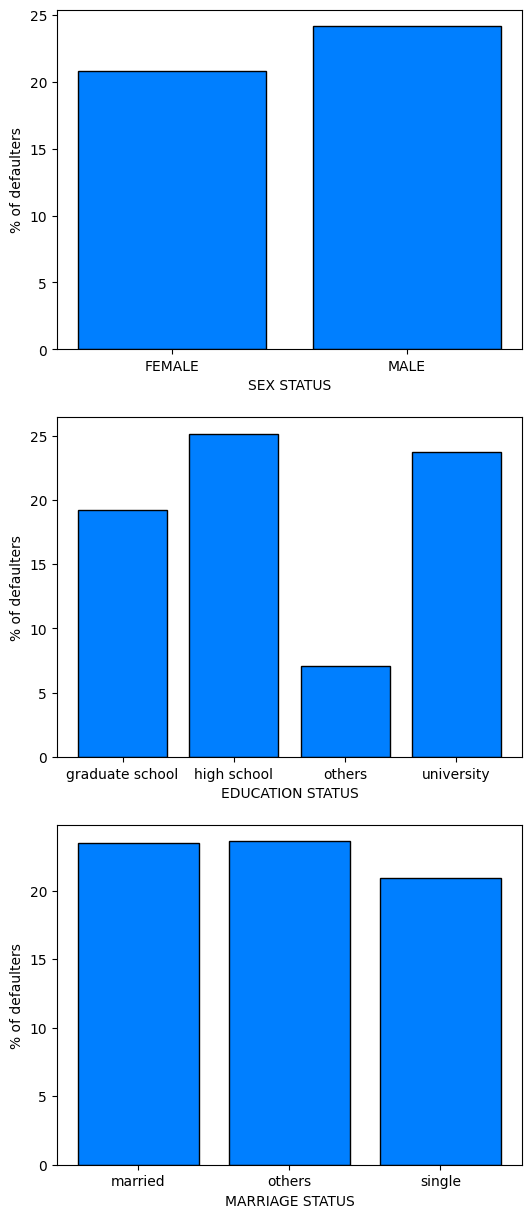

In [19]:
fig,ax = plt.subplots(nrows = 3, ncols = 1, figsize=(6,15))
for i,col in enumerate(cat_feat):
    eda_func(col,'default_flag',i)

#### Following trends can be interpreted from the bar graphs:
#### 1. Male are more prone to default then Female.
#### 2. People with higher educational degree are less prone to default.
#### 3. Single are less prone to default compared to other two categories.

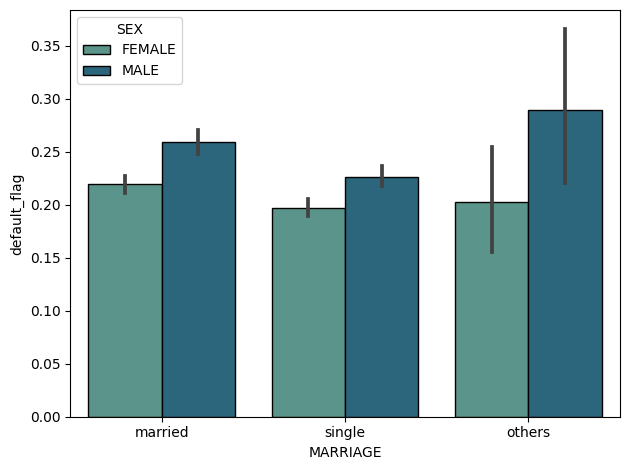

In [20]:
sns.barplot(data=cr_crd_df,x='MARRIAGE',y='default_flag',hue='SEX',palette='crest',edgecolor='black')
plt.tight_layout()

#### Married and Other(Divorced) Male has more probability of default.

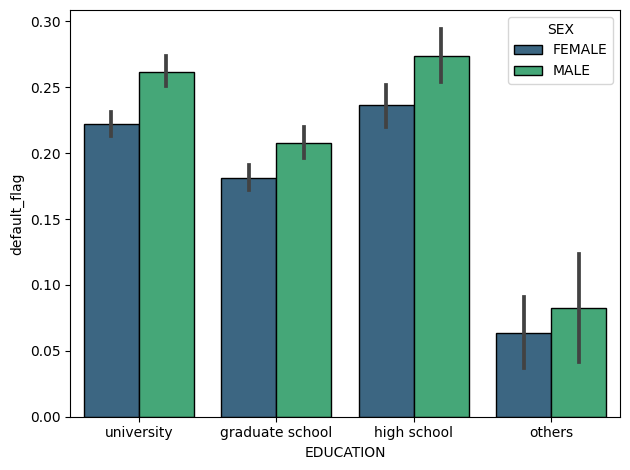

In [21]:
sns.barplot(data=cr_crd_df,x='EDUCATION',y='default_flag',hue='SEX',palette='viridis',edgecolor='black')
plt.tight_layout()

#### Male with University and High School education has higher probability to default

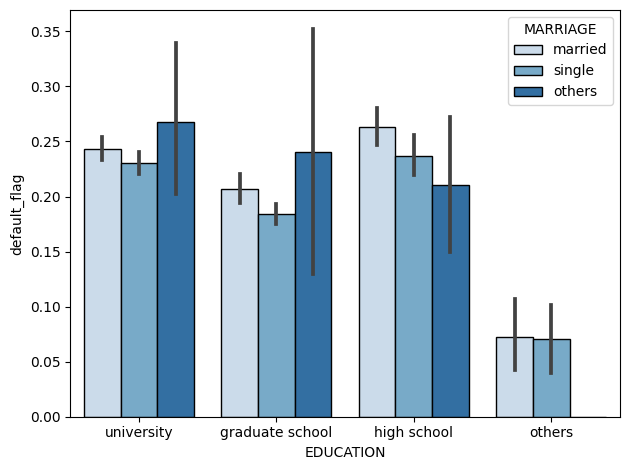

In [22]:
sns.barplot(data=cr_crd_df,x='EDUCATION',y='default_flag',hue='MARRIAGE',palette='Blues',edgecolor='black')
plt.tight_layout()

#### Others(Divorced) people who attended university and graduate school is more prone to default. 
#### Also Married people who attended only high school will default compared to people having other maritial status

#### 1.3.2 Numerical Variables EDA

In [23]:
#Pay Amount Columns
pay_flag_cols = ['PAY_SEP','PAY_AUG','PAY_JUL','PAY_JUN','PAY_MAY','PAY_APR']
cr_crd_df[pay_flag_cols].head()

,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR
0,2,2,-1,-1,-1,-1
1,-1,2,-1,-1,-1,2
2,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1


In [24]:
cr_crd_df[pay_flag_cols].describe()

,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.415967,-0.532033,-0.555500,-0.624233,-0.679567,-0.670800
std,1.142591,1.146393,1.126275,1.067522,1.001726,1.005283
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


#### Max value of Pay columns is 8. This means that borrower defaulted payment for 8 months. Let's explore the distribution of data.

In [25]:
# Plotting the histogram using seaborn
def plot_histogram(data,column_list,bin_size):
    fig,ax = plt.subplots(nrows=2,ncols= 3,figsize=(16,10))
    # Convert the numpy array of axes to a flat list
    ax_flat = ax.flatten()
    for i,pay_col in enumerate(column_list):
        sns.histplot(data=data,x=pay_col, bins=bin_size, kde=False, color='skyblue', edgecolor='black',ax=ax_flat[i])
        ax_flat[i].set_title(f'Histogram plot for {pay_col}')
        ax_flat[i].set_xlabel('Values')
        ax_flat[i].set_ylabel('Frequency')
    plt.tight_layout()

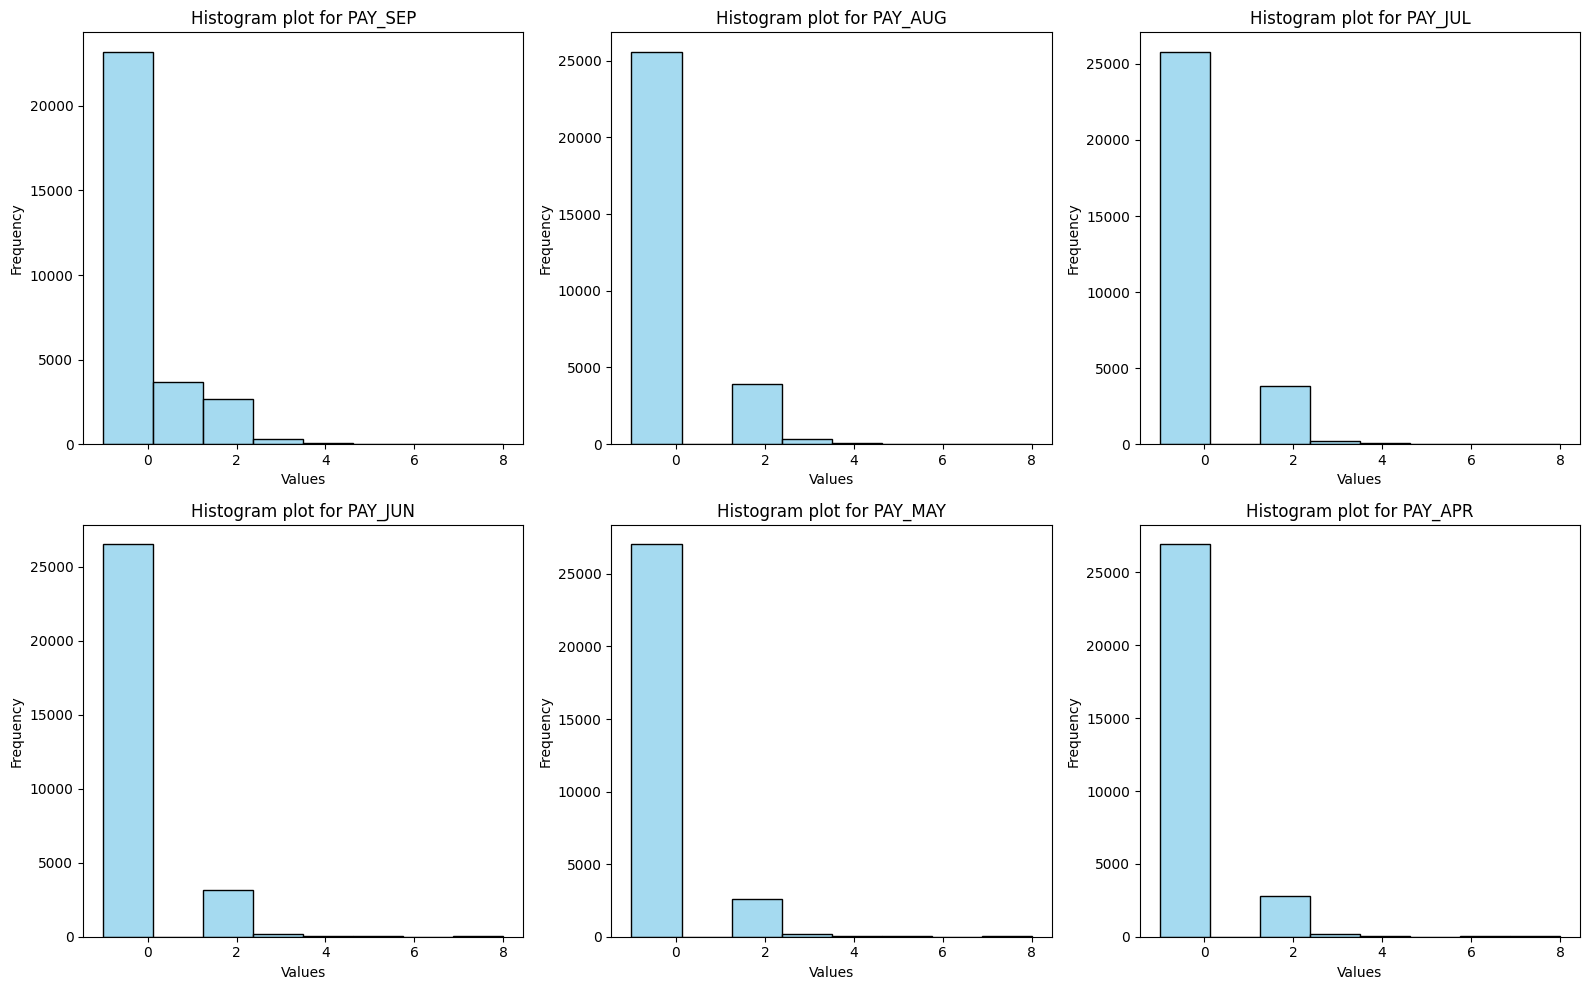

In [26]:
plot_histogram(cr_crd_df,pay_flag_cols,8)

#### The distribution shows that most of borrower donot default. But the distribution shows intresting trend. Most of the borrower defaulted payment for 2 months.

In [27]:
def plot_boxplot(data,column_list):
    fig,ax = plt.subplots(nrows=2,ncols= 3,figsize=(15,10))
    # Convert the numpy array of axes to a flat list
    ax_flat = ax.flatten()
    for i,pay_col in enumerate(column_list):
        sns.boxplot(data=data[pay_col],palette='magma',ax=ax_flat[i])
        ax_flat[i].set_title(f'Box Plot plot for {pay_col}')
    plt.tight_layout()
        

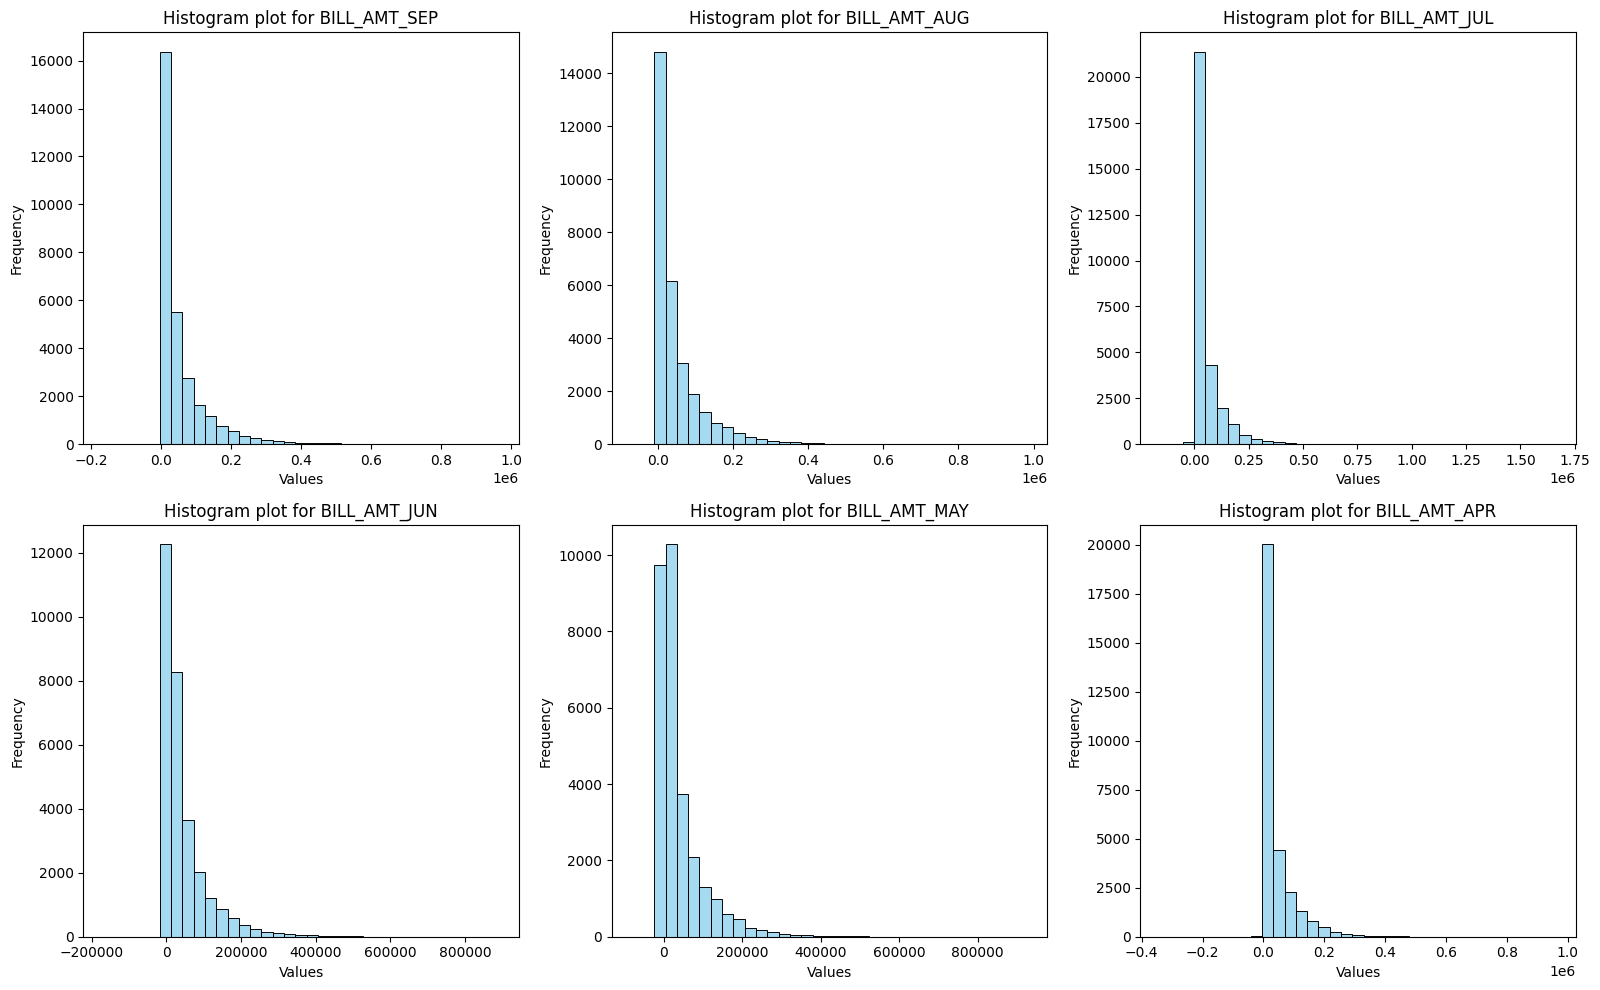

In [28]:
bill_amt_col = ['BILL_AMT_SEP','BILL_AMT_AUG','BILL_AMT_JUL','BILL_AMT_JUN','BILL_AMT_MAY','BILL_AMT_APR']
plot_histogram(cr_crd_df,bill_amt_col,35)

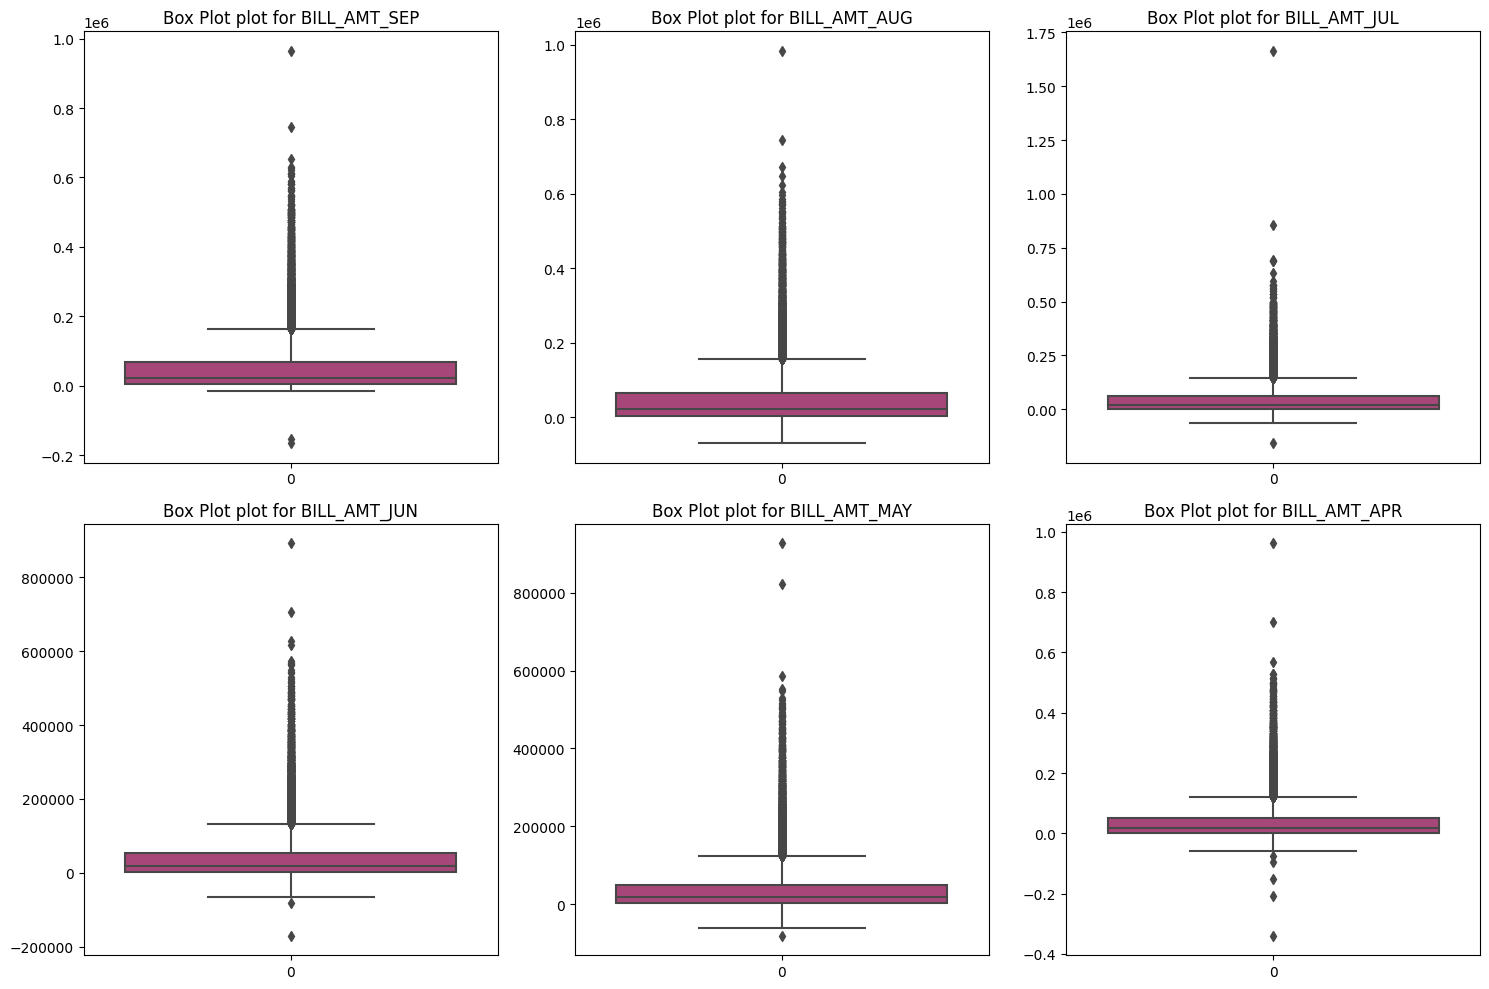

In [29]:
plot_boxplot(cr_crd_df,bill_amt_col)

#### The box plot shows many outliers in the bill amount columns. Mostly the bill amount greater than 250k NTD is shown as outlier for each column. Let us have a look into it.

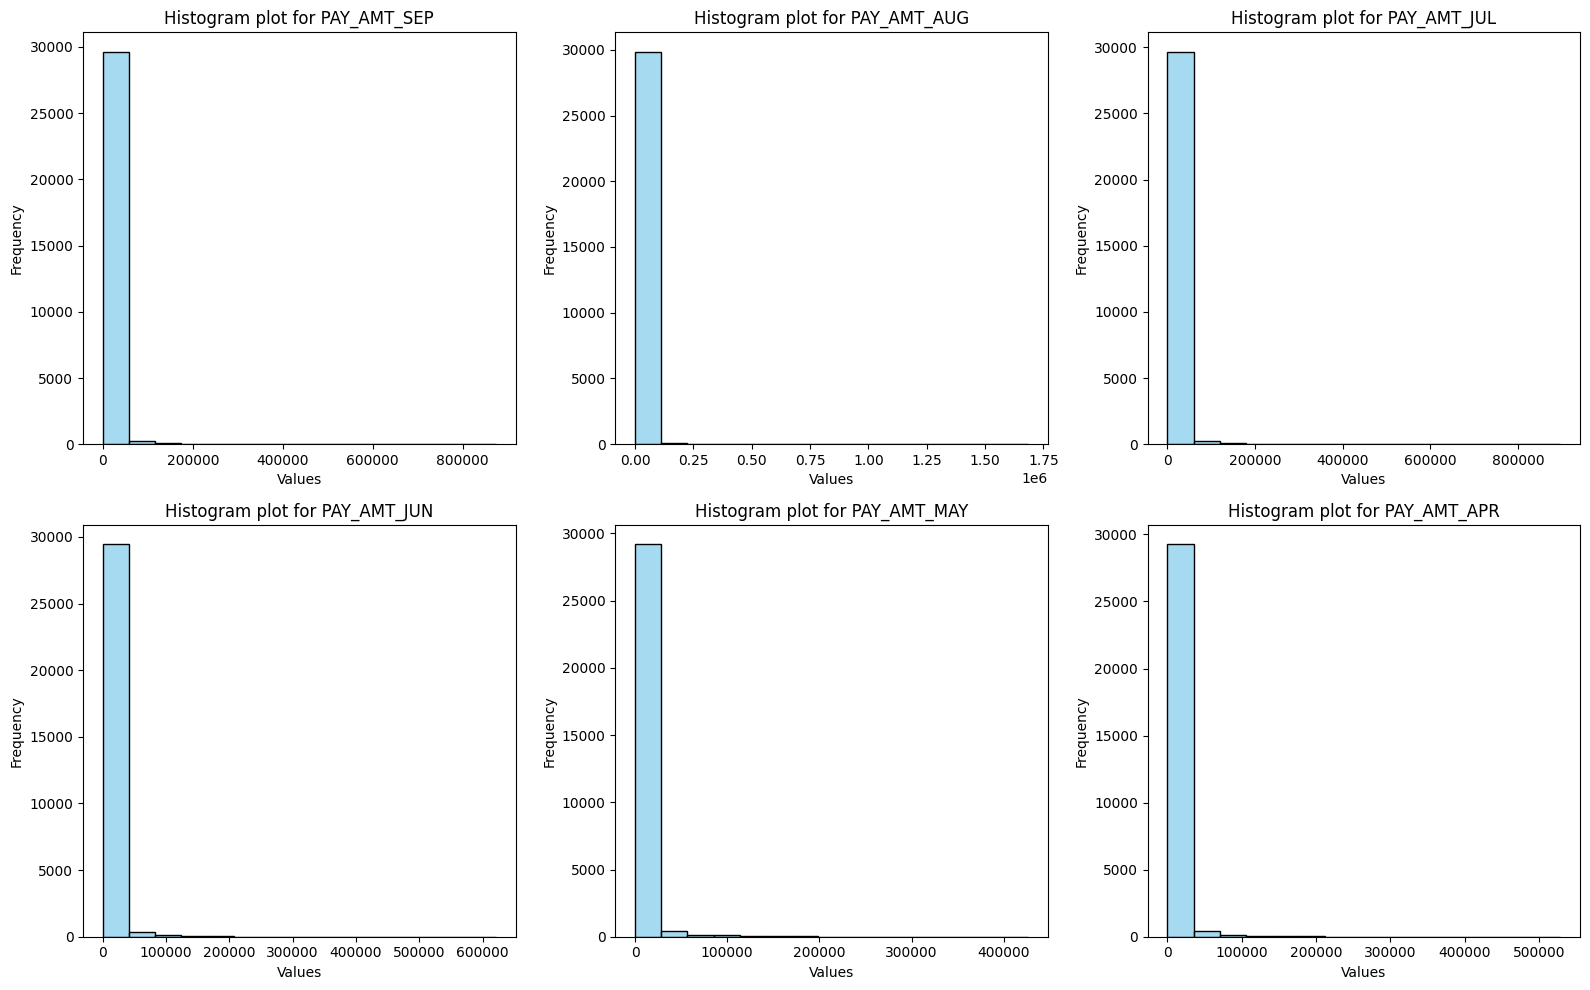

In [30]:
pay_amt_cols = ['PAY_AMT_SEP','PAY_AMT_AUG','PAY_AMT_JUL','PAY_AMT_JUN','PAY_AMT_MAY','PAY_AMT_APR']
plot_histogram(cr_crd_df,pay_amt_cols,15)

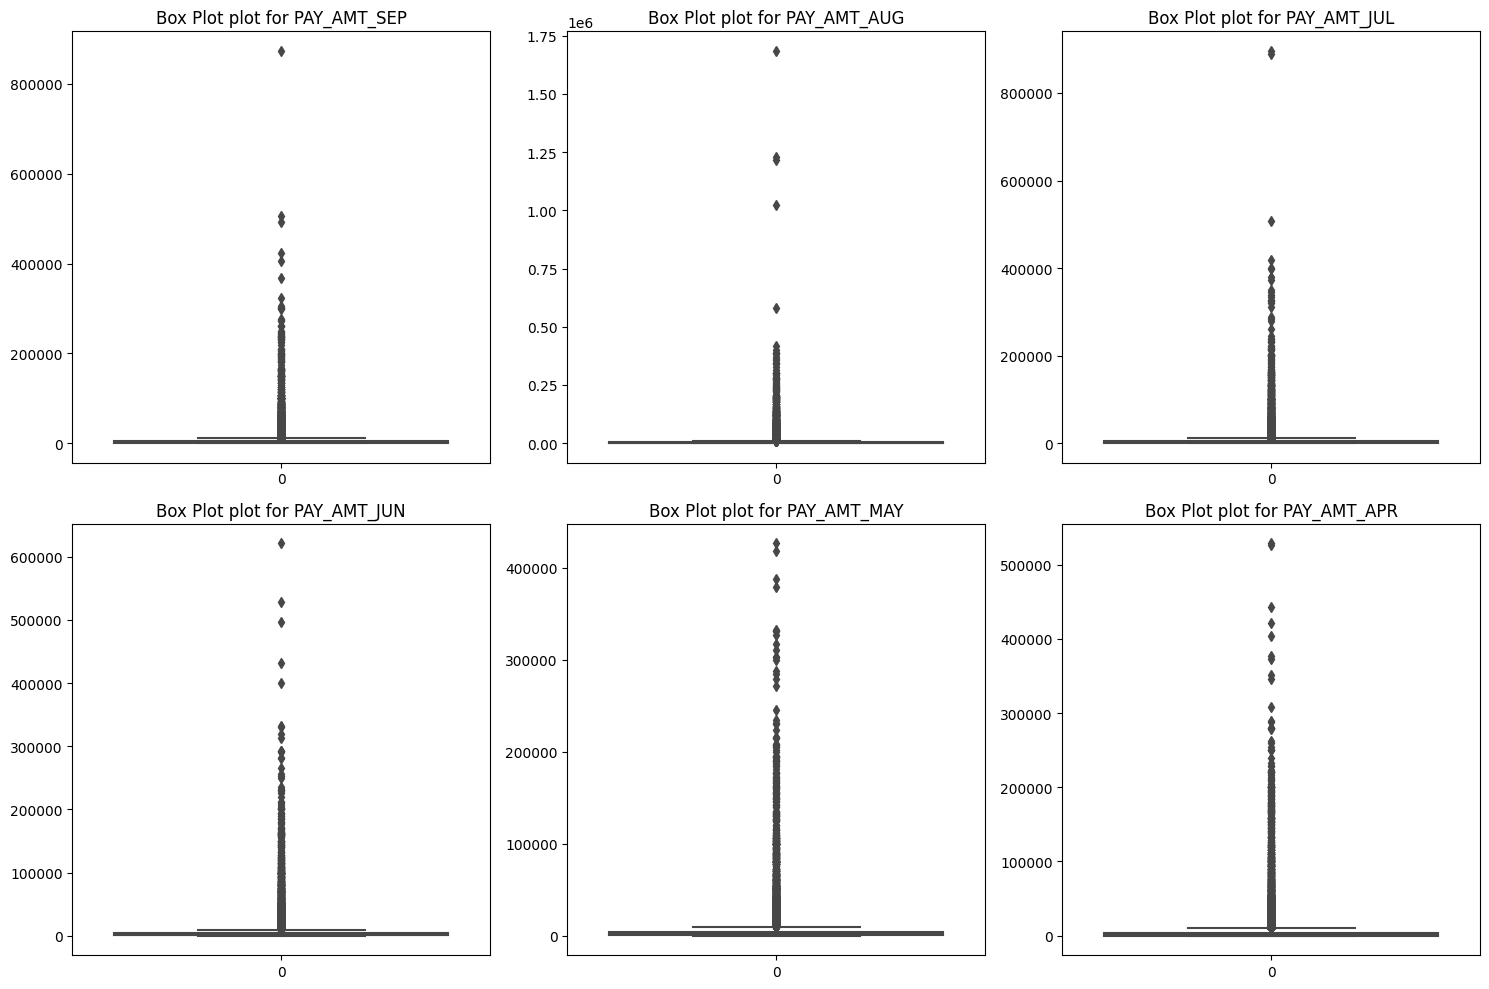

In [31]:
plot_boxplot(cr_crd_df,pay_amt_cols)

#### Payment Amount columns also indicates substaintial number of outliers present in the column. Let's look into sample data to figure out is it some kind of a trend or outlier.

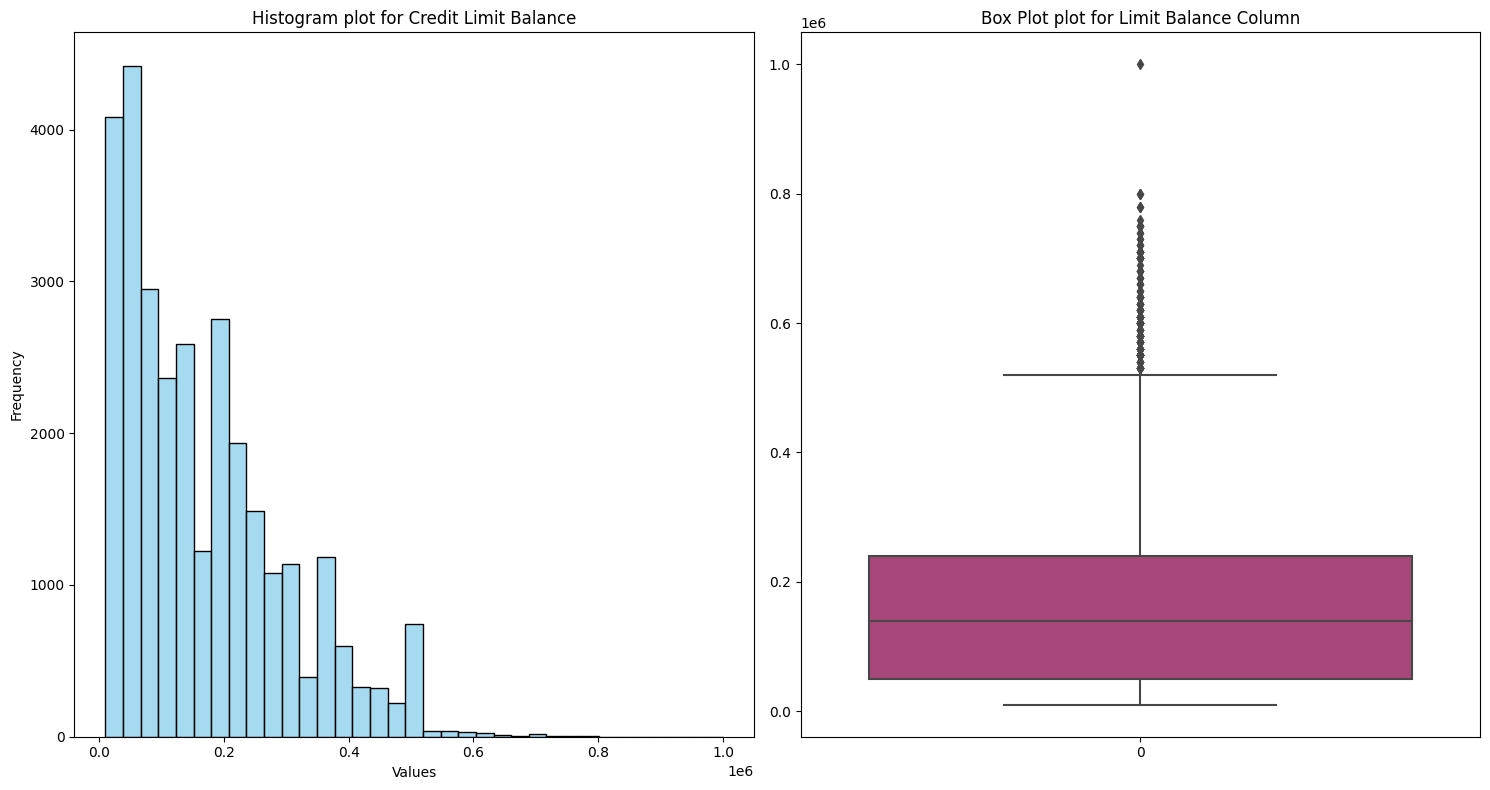

In [32]:
fig,ax = plt.subplots(nrows=1,ncols= 2,figsize=(15,8))
sns.histplot(data=cr_crd_df,x='LIMIT_BAL', bins=35, kde=False, color='skyblue', edgecolor='black',ax=ax[0])
ax[0].set_title('Histogram plot for Credit Limit Balance')
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Frequency')
sns.boxplot(data=cr_crd_df['LIMIT_BAL'],palette='magma',ax=ax[1])
ax[1].set_title(f'Box Plot plot for Limit Balance Column')
plt.tight_layout()

#### Boxplot indicates presence of outliers in Limit Balance Column

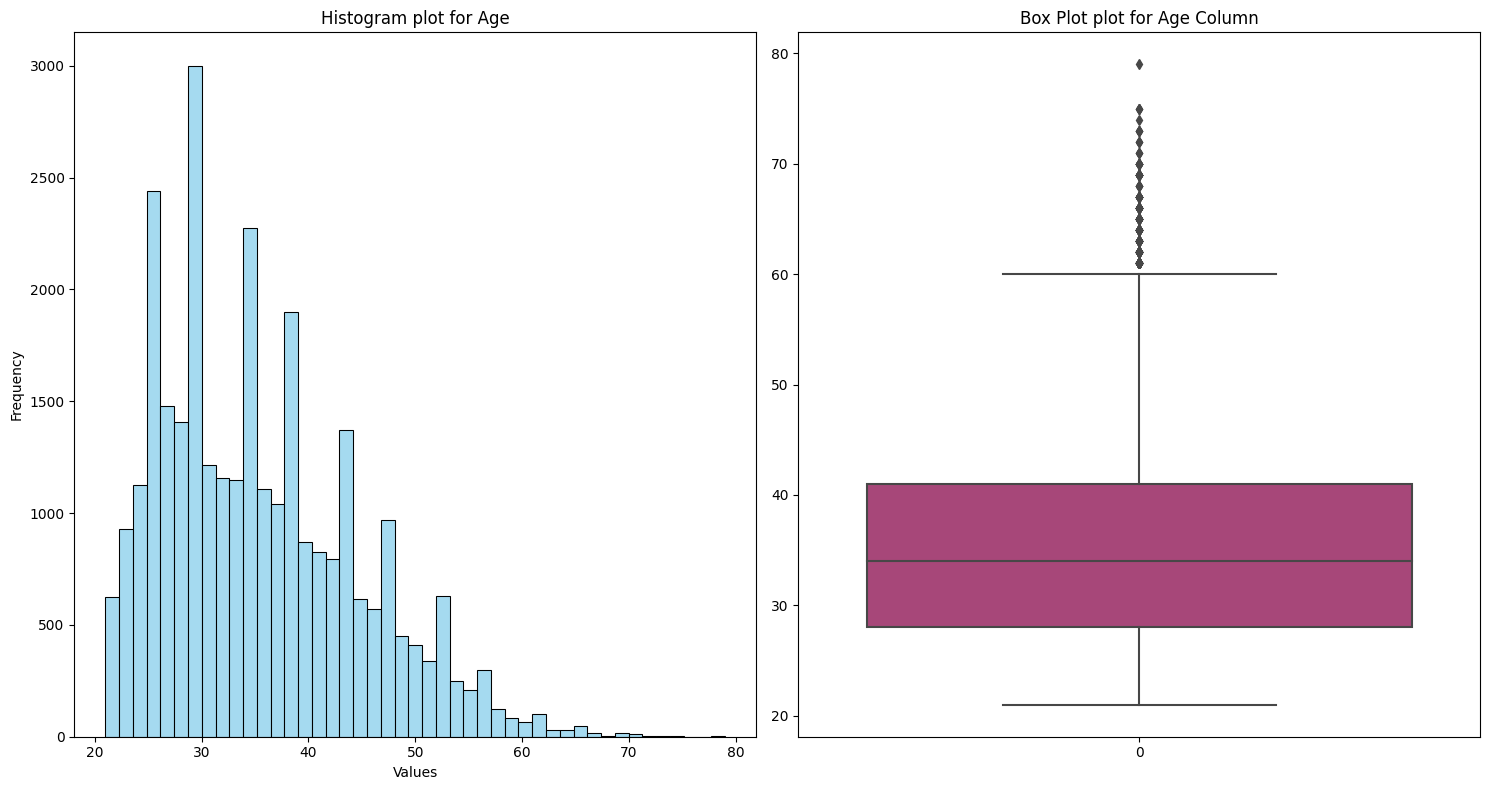

In [33]:
fig,ax = plt.subplots(nrows=1,ncols= 2,figsize=(15,8))
sns.histplot(data=cr_crd_df,x='AGE', bins=45, kde=False, color='skyblue', edgecolor='black',ax=ax[0])
ax[0].set_title('Histogram plot for Age')
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Frequency')
sns.boxplot(data=cr_crd_df['AGE'],palette='magma',ax=ax[1])
ax[1].set_title(f'Box Plot plot for Age Column')
plt.tight_layout()

In [34]:
cr_crd_df.loc[cr_crd_df.BILL_AMT_SEP > 250000,:].sample(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_AMT_JUN,BILL_AMT_MAY,BILL_AMT_APR,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,default_flag
21077,21078,280000.0,MALE,graduate school,single,36,1,2,-1,-1,...,275447.0,245409.0,211351.0,0.0,13500.0,14500.0,10000.0,9000.0,12000.0,0
10037,10038,390000.0,FEMALE,high school,single,30,-1,-1,-1,-1,...,184529.0,175781.0,173442.0,8738.0,6545.0,6601.0,5700.0,6100.0,5000.0,0
17194,17195,450000.0,FEMALE,university,single,29,-1,-1,-1,-1,...,31126.0,18345.0,12836.0,10000.0,1500.0,2109.0,5000.0,1000.0,3020.0,0
24888,24889,310000.0,MALE,high school,single,34,-1,-1,-1,-1,...,166942.0,140659.0,145379.0,8000.0,6650.0,6000.0,6000.0,7000.0,6000.0,0
10516,10517,350000.0,FEMALE,university,single,33,-1,-1,-1,-1,...,182381.0,194678.0,215024.0,50070.0,10000.0,8000.0,15036.0,30050.0,8110.0,0
10674,10675,290000.0,FEMALE,university,single,36,-1,-1,-1,-1,...,296053.0,302793.0,307336.0,11149.0,10524.0,10600.0,11500.0,10000.0,65000.0,0
9482,9483,280000.0,FEMALE,graduate school,married,47,-1,-1,-1,-1,...,194345.0,161084.0,174622.0,20000.0,15000.0,0.0,161084.0,15000.0,20000.0,0
1181,1182,390000.0,FEMALE,graduate school,single,27,2,-1,-1,-1,...,295606.0,300709.0,305904.0,17000.0,11000.0,11000.0,10656.0,11000.0,12000.0,0
25436,25437,360000.0,FEMALE,graduate school,single,27,-1,-1,-1,-1,...,289355.0,274484.0,247998.0,20000.0,15000.0,19355.0,10000.0,10000.0,10000.0,0
4787,4788,390000.0,FEMALE,graduate school,single,28,-1,-1,-1,-1,...,175268.0,167781.0,147878.0,11000.0,11000.0,5600.0,5700.0,5600.0,3400.0,0


#### From the sample data it can be infered that the datapoints shown as outliers in boxplot analysis for columns bill_amt_col and pay_amt_col are not actually outliers. They are data points that represent wealthy people. 

In [35]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

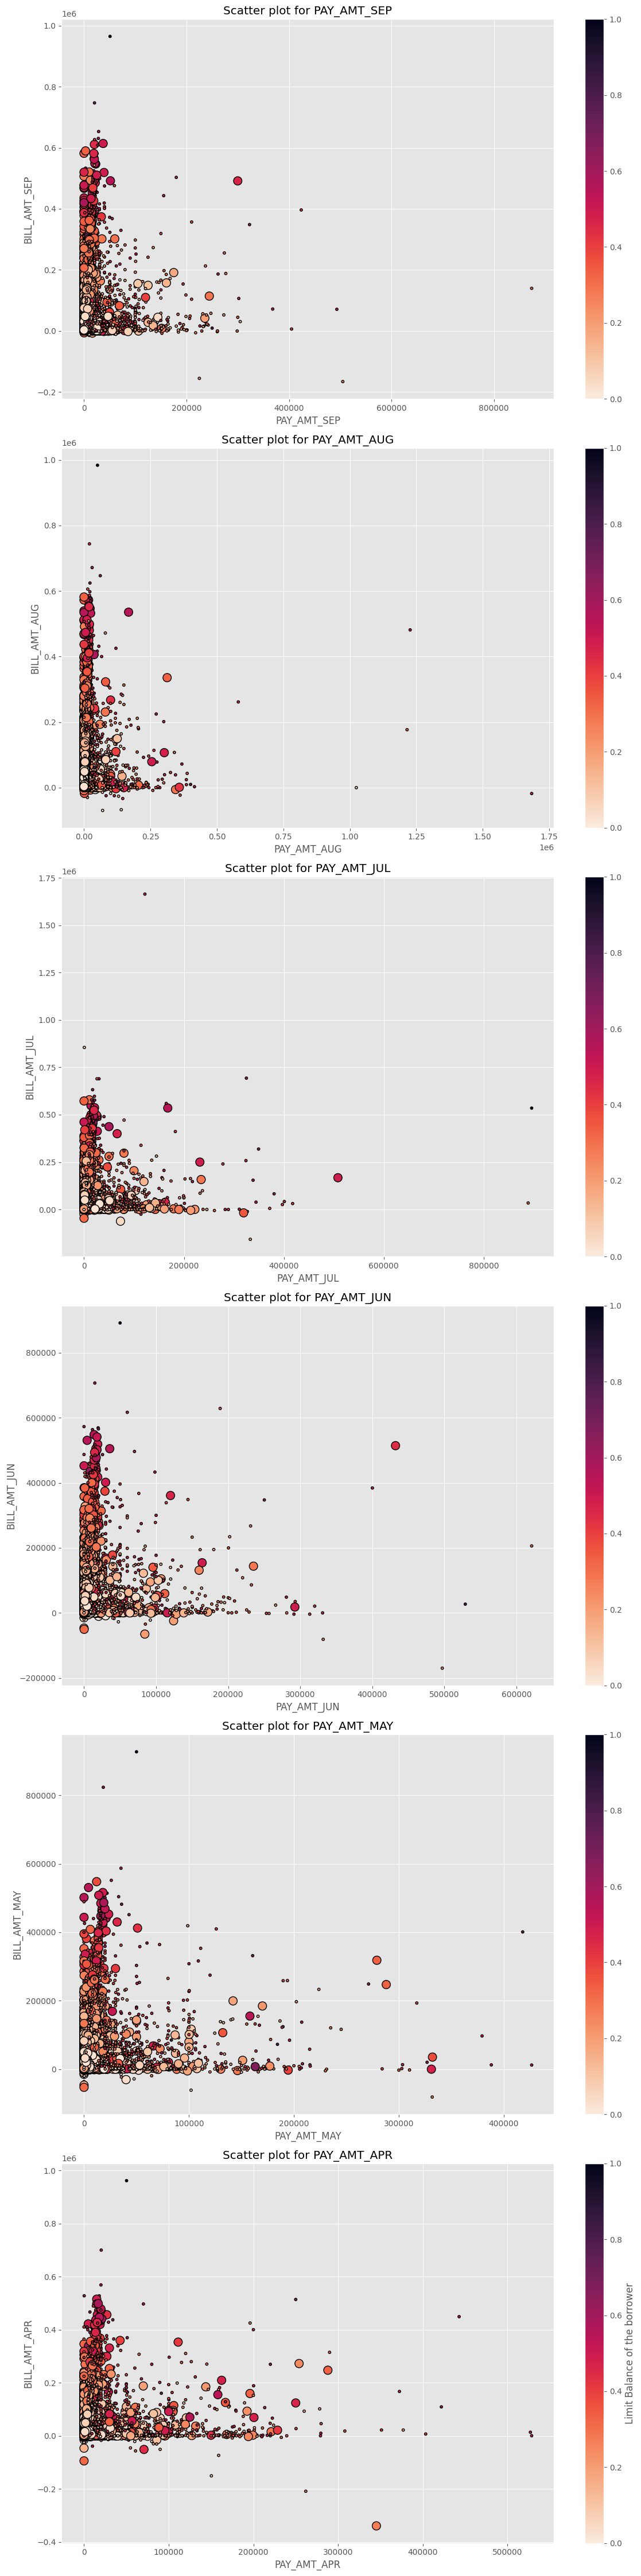

In [36]:
plt.style.use('ggplot')
fig,ax = plt.subplots(nrows=6,ncols= 1,figsize=(12,45))
ax_flat = ax.flatten()
for i,pay_col in enumerate(pay_amt_cols):
    pay_amt_column = pay_amt_cols[i]
    cmap='rocket_r'
    bill_amt_column = bill_amt_col[i]
    ax_flat[i].scatter(cr_crd_df[pay_amt_column],cr_crd_df[bill_amt_column],cmap=cmap,c=cr_crd_df['LIMIT_BAL'],s=cr_crd_df['default_flag']*100 + 10,edgecolor='black',linewidth=1)
    ax_flat[i].set_title(f'Scatter plot for {pay_col}')
    ax_flat[i].set_xlabel(f'{pay_col}')
    ax_flat[i].set_ylabel(f'{bill_amt_col[i]}')
    cbar=plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax_flat[i])
cbar.set_label('Limit Balance of the borrower')
plt.tight_layout()


#### Following observations can be infered from the scatter plot:
#### 1. The size of bubble shows the defaulter status. The bigger bubbles belongs to people who defauled. Most of the big bubbles in the plot are situated in the left bottom corner. This indicates that people with high bill amount and less payment amount are more prone to default. 
#### 2. The shade of color shows the credit limit of borrower. Most of big bubbles are light in color. Very few bubbles are dark. This indicates that people having lesser credit limit has high probablity to default the payment.

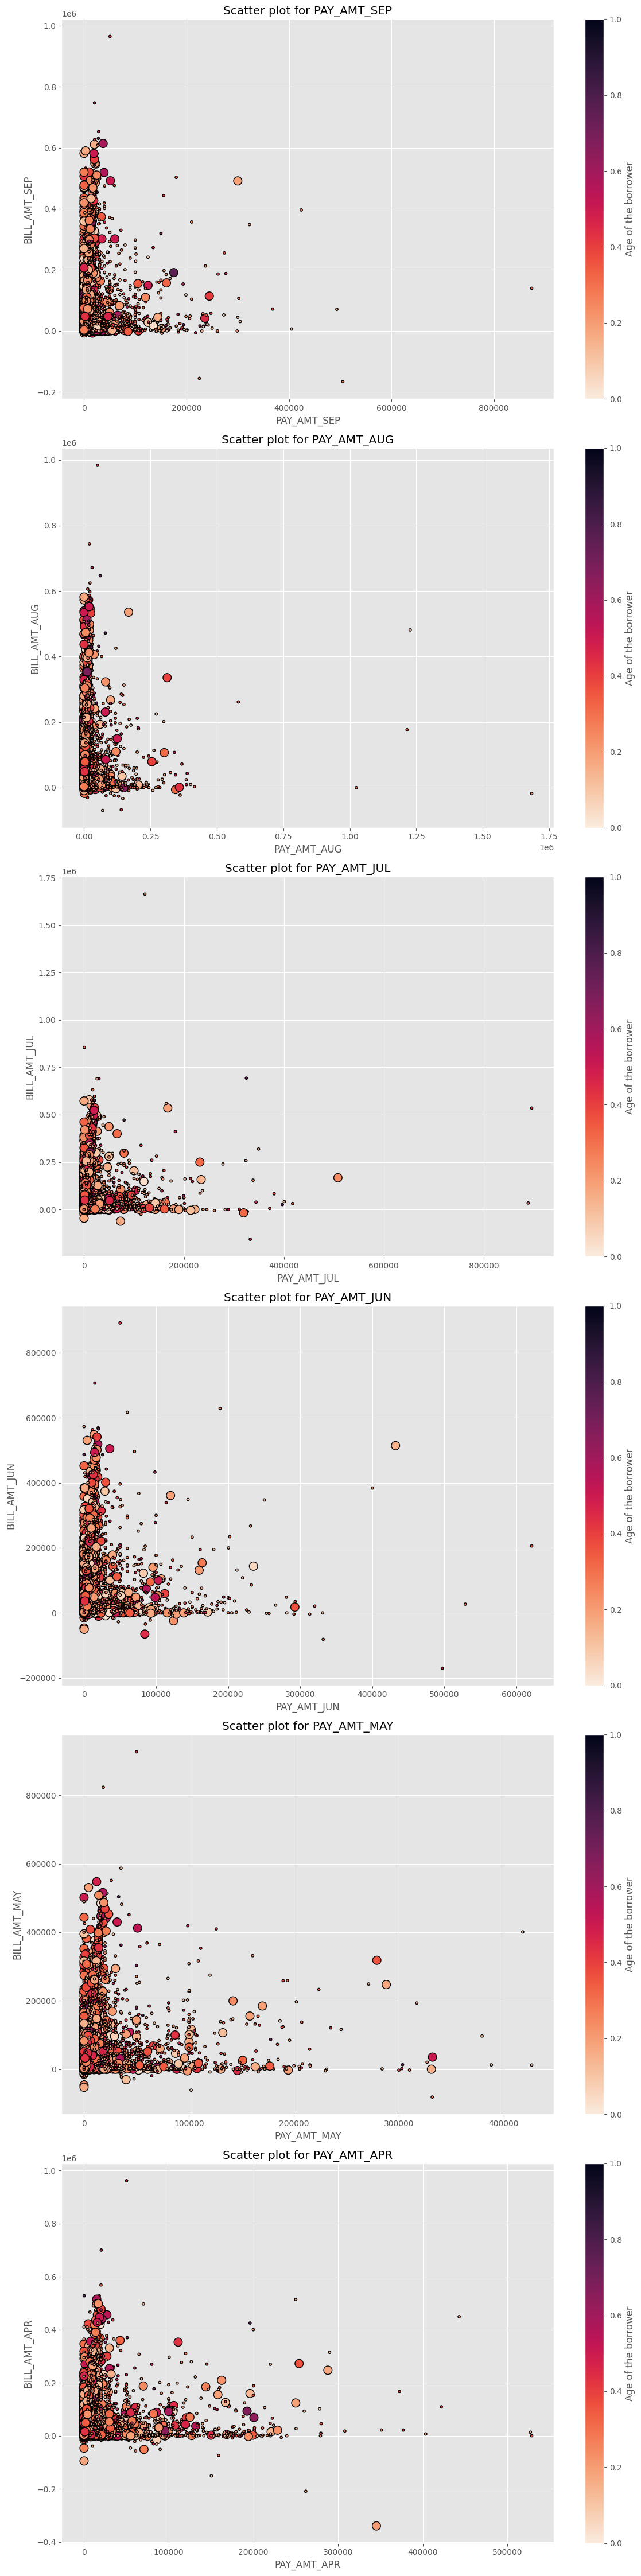

In [37]:
plt.style.use('ggplot')
fig,ax = plt.subplots(nrows=6,ncols= 1,figsize=(12,45))
ax_flat = ax.flatten()
plt.title('Scatter plot of Payment vs Bill Amount w.r.t Age and default status of Borrower')
for i,pay_col in enumerate(pay_amt_cols):
    pay_amt_column = pay_amt_cols[i]
    cmap='rocket_r'
    bill_amt_column = bill_amt_col[i]
    ax_flat[i].scatter(cr_crd_df[pay_amt_column],cr_crd_df[bill_amt_column],cmap=cmap,c=cr_crd_df['AGE'],s=cr_crd_df['default_flag']*100 + 10,edgecolor='black',linewidth=1)
    ax_flat[i].set_title(f'Scatter plot for {pay_col}')
    ax_flat[i].set_xlabel(f'{pay_col}')
    ax_flat[i].set_ylabel(f'{bill_amt_col[i]}')
    cbar=plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax_flat[i])
    cbar.set_label('Age of the borrower')
plt.tight_layout()

#### It is observed that different age group people have different payment amount and bill amount. Also there can be seen that color of big bubbles is mostly light. It indicates a possibility of trend of defaulting based on different age bucket.

#### 1.4 Feature Engineering

#### We have seen during EDA of categorical variable that defaulter probability changes with combination of defaulter marraige and sex state. Thus, creating a new variable that defines combination of these states will be helpful in predicting default probability. 

#### As our EDA is completed let us encode all categorical values into numbers

In [38]:
# Replacing categorical description to encoded numbers
cr_crd_df.replace({'SEX': {'MALE' : 1, 'FEMALE' : 2}, 'EDUCATION' : {'graduate school' : 1, 'university' : 2 , 'high school': 3, 'others' : 4}, 'MARRIAGE' : {'married' : 1, 'single' : 2, 'others' : 3}}, inplace = True)

In [39]:
#Creating a function that provides a new feature that is combination of two columns
def two_cols_combination_encoder(col1,col2):
    col1_unique_list = list(cr_crd_df[col1].unique())
    col2_unique_list = list(cr_crd_df[col2].unique())
    comb_col_name = col1 + '_'+ col2 + '_STATE'
    cr_crd_df[comb_col_name] = 0
    w=1
    for i in col1_unique_list:
        for j in col2_unique_list:
            cr_crd_df.loc[((cr_crd_df[col1] == i) & (cr_crd_df[col2] == j)),comb_col_name] = w
            w=w+1

In [40]:
#Creating a function that provides a new feature that is combination of three columns
def three_cols_combination_encoder(col1,col2,col3):
    col1_unique_list = list(cr_crd_df[col1].unique())
    col2_unique_list = list(cr_crd_df[col2].unique())
    col3_unique_list = list(cr_crd_df[col3].unique())
    comb_col_name = col1 + '_'+ col2 + '_' + col3 + '_STATE'
    cr_crd_df[comb_col_name] = 0
    w = 1
    for i in col1_unique_list:
        for j in col2_unique_list:
            for k in col3_unique_list:
                cr_crd_df.loc[((cr_crd_df[col1] == i) & (cr_crd_df[col2] == j) & (cr_crd_df[col3] == k)),comb_col_name] = w
                w=w+1

In [41]:
two_cols_combination_encoder('EDUCATION','MARRIAGE')
two_cols_combination_encoder('EDUCATION','SEX')
two_cols_combination_encoder('MARRIAGE','SEX')
three_cols_combination_encoder('EDUCATION','MARRIAGE','SEX')

In [42]:
# Forming bucket of Age column:
cr_crd_df['Age_Bucket'] = pd.cut(cr_crd_df['AGE'], 6, labels = [1,2,3,4,5,6])
#because 1 2 3 ecc are "categories" so far and we need numbers
cr_crd_df['Age_Bucket'] = pd.to_numeric(cr_crd_df['Age_Bucket'])
cr_crd_df.loc[(cr_crd_df['Age_Bucket'] == 6) , 'Age_Bucket'] = 5

In [43]:
# Finding combination of Marriage,Sex and Age
two_cols_combination_encoder('Age_Bucket','SEX')
two_cols_combination_encoder('Age_Bucket','MARRIAGE')
two_cols_combination_encoder('Age_Bucket','EDUCATION')

In [44]:
# Forming bucket of LIMIT_BAL column:
cr_crd_df['Credit_Limit_Bucket'] = pd.qcut(cr_crd_df['LIMIT_BAL'],5, labels = [1,2,3,4,5])
cr_crd_df['Credit_Limit_Bucket'] = pd.to_numeric(cr_crd_df['Credit_Limit_Bucket'])

In [45]:
# Forming bucket of PAY_AMT column:
for col in pay_amt_cols:
    bucket_col_name = col + '_Bucket'
    cr_crd_df[bucket_col_name] = pd.qcut(cr_crd_df[col],4, labels = [1,2,3,4])
    cr_crd_df[bucket_col_name] = pd.to_numeric(cr_crd_df[bucket_col_name])

In [46]:
# Forming bucket of BILL_AMT_column
for col in bill_amt_col:
    bucket_col_name = col + '_Bucket'
    cr_crd_df[bucket_col_name] = pd.qcut(cr_crd_df[col],5, labels = [1,2,3,4,5])
    cr_crd_df[bucket_col_name] = pd.to_numeric(cr_crd_df[bucket_col_name])

#### Number 1 in PAY_AMT_MTH_BUCKET indicates lower pay amount and Number 4 indicates high pay amount.
#### Number 1 in BILL_AMT_MTH_BUCKET indicates lower bill amount and Number 5 indicates high bill amount.
#### When a default occurs?
#### When a borrower pays less and buys more. Thus the bucket parameter Avg Bill Bucket Number - Avg Pay Bucket Number is an important feature.

In [47]:
cr_crd_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,PAY_AMT_JUL_Bucket,PAY_AMT_JUN_Bucket,PAY_AMT_MAY_Bucket,PAY_AMT_APR_Bucket,BILL_AMT_SEP_Bucket,BILL_AMT_AUG_Bucket,BILL_AMT_JUL_Bucket,BILL_AMT_JUN_Bucket,BILL_AMT_MAY_Bucket,BILL_AMT_APR_Bucket
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,1,1,1,1,2,2,1,1,1,1
1,2,120000.0,2,2,2,26,-1,2,-1,-1,...,2,2,1,3,2,2,2,2,2,2
2,3,90000.0,2,2,2,34,-1,-1,-1,-1,...,2,2,2,4,3,3,3,3,3,3
3,4,50000.0,2,2,1,37,-1,-1,-1,-1,...,2,2,2,2,4,4,4,3,4,4
4,5,50000.0,1,2,1,57,-1,-1,-1,-1,...,4,4,2,2,2,2,4,3,3,3


In [48]:
# bill_amt_bucket - pay_amt_bucket is an essential feature that captures default behaviour of borrower. More the value, higher is the probability of default.
cr_crd_df['bill_amt_pay_amt_avg_bucket'] = cr_crd_df['BILL_AMT_SEP_Bucket'] + cr_crd_df['BILL_AMT_AUG_Bucket'] + cr_crd_df['BILL_AMT_JUL_Bucket'] + cr_crd_df['BILL_AMT_JUN_Bucket'] + cr_crd_df['BILL_AMT_MAY_Bucket']\
                                           + cr_crd_df['BILL_AMT_APR_Bucket'] - (cr_crd_df['PAY_AMT_SEP_Bucket'] + cr_crd_df['PAY_AMT_AUG_Bucket'] + cr_crd_df['PAY_AMT_JUL_Bucket'] + cr_crd_df['PAY_AMT_JUN_Bucket']\
                                           + cr_crd_df['PAY_AMT_MAY_Bucket'] + cr_crd_df['PAY_AMT_APR_Bucket'])

In [49]:
# (bill_amt_bucket - pay_amt)/crdeit limit balance is an essential feature that captures default behaviour of borrower w.r.t his/her capacity. More the value, higher is the probability of default.
cr_crd_df['bill_amt_lim_bal_pay_amt'] = (cr_crd_df['BILL_AMT_SEP'] + cr_crd_df['BILL_AMT_AUG'] + cr_crd_df['BILL_AMT_JUL'] + cr_crd_df['BILL_AMT_JUN'] + cr_crd_df['BILL_AMT_MAY']\
                                           + cr_crd_df['BILL_AMT_APR'] - (cr_crd_df['PAY_AMT_SEP'] + cr_crd_df['PAY_AMT_AUG'] + cr_crd_df['PAY_AMT_JUL'] + cr_crd_df['PAY_AMT_JUN']\
                                           + cr_crd_df['PAY_AMT_MAY'] + cr_crd_df['PAY_AMT_APR']))/cr_crd_df['LIMIT_BAL']

In [50]:
# (bill_amt_bucket - pay_amt)/crdeit limit balance feature for current month. This is essential to capture current financial status of borrower. Based on this financial status, borrower may or may not default next month.
cr_crd_df['bill_amt_pay_amt_sep'] = (cr_crd_df['BILL_AMT_SEP'] - cr_crd_df['PAY_AMT_SEP'])/cr_crd_df['LIMIT_BAL']

#### 1.5 Model Building

In [51]:
cr_crd_df.drop(columns='ID',inplace=True)

In [52]:
Y = cr_crd_df['default_flag']
X = cr_crd_df.drop(columns='default_flag')

In [53]:
scaler= StandardScaler()
X_scale= scaler.fit_transform(X)

#### The credit risk model data possess unbalance proportion of 0 and 1 labels. Because of more number of 0 labels, training model on this data would result in biasness of model. To avoid this, extra number of data points for label 1 is generated using Synthetic Minority Over Sampling Technique (SMOTE).

In [54]:
# summarize class distribution
print("Before oversampling: ",Counter(Y))

# define oversampling strategy
SMOTE= SMOTE()

# fit and apply the transform 
X_smote,Y_smote= SMOTE.fit_resample(X_scale,Y)

# summarize class distribution
print("After oversampling: ",Counter(Y_smote))

Before oversampling:  Counter({0: 23364, 1: 6636})
After oversampling:  Counter({1: 23364, 0: 23364})


In [55]:
X_train,X_test,Y_train,Y_test= train_test_split(X_smote,Y_smote,test_size=0.25,random_state=50)

#### 1.5.1 Logistic Regression

In [56]:
params = {'penalty':['l1','l2'], 'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid_lr = GridSearchCV(LogisticRegression(), params, scoring = 'f1', n_jobs = -1, verbose = 3, cv = 3)
grid_lr.fit(X_train, Y_train)
optimized_logistic_reg = grid_lr.best_estimator_
grid_lr.best_params_
print(grid_lr.best_score_)
# Predicting the model
pred = optimized_logistic_reg.predict(X_test)
print("The accuracy of logit model is:", accuracy_score(Y_test, pred))
print(classification_report(Y_test, pred))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
0.6794266288122351
The accuracy of logit model is: 0.7026194144838213
              precision    recall  f1-score   support

           0       0.68      0.78      0.73      5873
           1       0.74      0.62      0.67      5809

    accuracy                           0.70     11682
   macro avg       0.71      0.70      0.70     11682
weighted avg       0.71      0.70      0.70     11682



In [57]:
# Get the confusion matrix for test data
def get_confusion_matrix(y_pred):
    labels = ['Not Defaulter', 'Defaulter']
    cm = confusion_matrix(Y_test,y_pred)
    print(cm)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap='BuPu') #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

[[4607 1266]
 [2208 3601]]


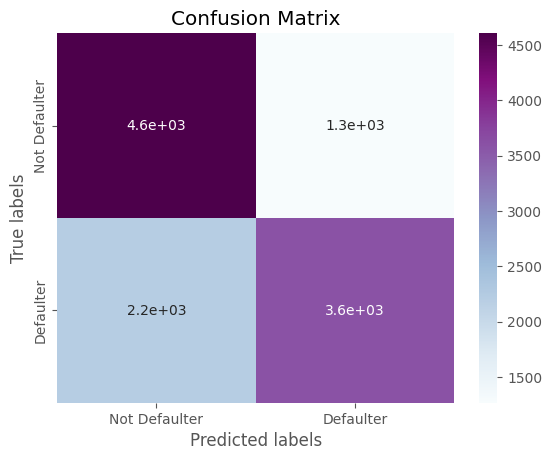

In [58]:
get_confusion_matrix(pred)

#### 1.5.2 Support Vector Model

In [59]:
'''param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_clf = GridSearchCV(SVC(), param_grid, scoring = 'f1', n_jobs = -1, verbose = 3, cv = 3)
optimized_grid_clf = grid_clf.best_estimator_
grid_clf.best_params_
print(grid_clf.best_score_) '''
grid_clf = SVC(C=100)
grid_clf.fit(X_train, Y_train)
# Predicting the model
pred = grid_clf.predict(X_test)
print("The accuracy of SVC model is:", accuracy_score(Y_test, pred))
print(classification_report(Y_test, pred))

[CV 1/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/3] END ...............C=0.001, penalty=l2;, score=0.677 total time=   0.2s
[CV 3/3] END ................C=0.01, penalty=l2;, score=0.687 total time=   0.5s
[CV 1/3] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 2/3] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 3/3] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 1/3] END ...................C=1, penalty=l2;, score=0.670 total time=   0.7s
[CV 2/3] END ..................C=10, penalty=l2;, score=0.681 total time=   0.6s
[CV 3/3] END .................C=100, penalty=l2;, score=0.687 total time=   0.7s
[CV 3/3] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/3] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 3/3] END ...............

[[4585 1288]
 [ 797 5012]]


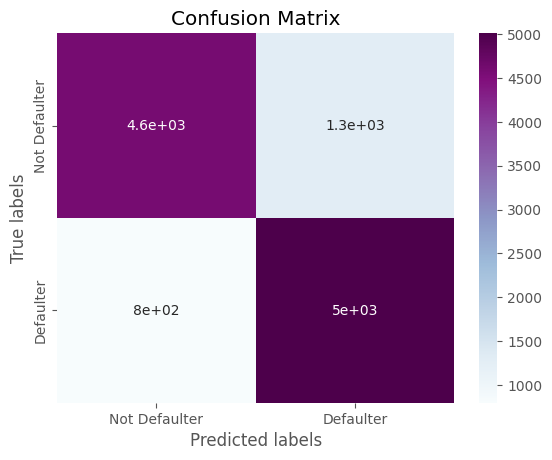

In [60]:
get_confusion_matrix(pred)

#### 1.5.3 Random Forest Classifier

In [61]:
'''# normal training set
param_grid = {'n_estimators': [200, 300,400,500, 600],
              'criterion': ['entropy', 'gini'],
              'class_weight' : ['balanced'], 'n_jobs' : [-1]} #use all the computational power you have
acc_scorer = make_scorer(f1_score)
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_forest = grid_forest.fit(X_train, Y_train)
print(grid_forest.best_estimator_)
print(grid_forest.best_score_)
forest_normal = grid_forest.best_estimator_
 RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       n_estimators=400, n_jobs=-1) '''

"# normal training set\nparam_grid = {'n_estimators': [200, 300,400,500, 600],\n              'criterion': ['entropy', 'gini'],\n              'class_weight' : ['balanced'], 'n_jobs' : [-1]} #use all the computational power you have\nacc_scorer = make_scorer(f1_score)\ngrid_forest = GridSearchCV(RandomForestClassifier(), param_grid, scoring = acc_scorer, cv=5)\n%time grid_forest = grid_forest.fit(X_train, Y_train)\nprint(grid_forest.best_estimator_)\nprint(grid_forest.best_score_)\nforest_normal = grid_forest.best_estimator_\n RandomForestClassifier(class_weight='balanced', criterion='entropy',\n                       n_estimators=400, n_jobs=-1) "

In [62]:
optimized_rf = RandomForestClassifier(class_weight='balanced', criterion='entropy',n_estimators=400, n_jobs=-1)
optimized_rf.fit(X_train,Y_train)
pred = optimized_rf.predict(X_test)
print("The accuracy of Random Forest model is:", accuracy_score(Y_test, pred))
print(classification_report(Y_test, pred))

The accuracy of Random Forest model is: 0.889060092449923
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      5873
           1       0.91      0.86      0.89      5809

    accuracy                           0.89     11682
   macro avg       0.89      0.89      0.89     11682
weighted avg       0.89      0.89      0.89     11682



[[5363  510]
 [ 786 5023]]


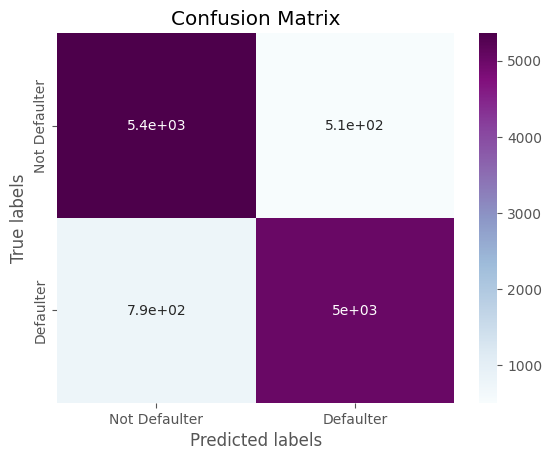

In [63]:
get_confusion_matrix(pred)

#### 1.5.4 Xtreme Gradient Boosting

In [64]:
'''param_grid = {'n_estimators': [200, 300,400,500, 600],
              'criterion': ['entropy', 'gini'],
              'class_weight' : ['balanced'], 'n_jobs' : [-1]}
acc_scorer = make_scorer(f1_score)
grid_xgbc = GridSearchCV(XGBClassifier(), param_grid, scoring = acc_scorer, cv=5)
%time grid_xgbc = grid_xgbc.fit(X_train, Y_train)
print(grid_xgbc.best_estimator_)
print(grid_xgbc.best_score_)'''
xgbc_normal = XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, criterion='entropy',
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1)

In [65]:
xgbc_normal.fit(X_train,Y_train)
xgbc_pred = xgbc_normal.predict(X_test)
print("The accuracy of Xtreme Gradient Boosting model is:", accuracy_score(Y_test, xgbc_pred))
print(classification_report(Y_test, xgbc_pred))

The accuracy of Xtreme Gradient Boosting model is: 0.8756206129087485
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      5873
           1       0.91      0.83      0.87      5809

    accuracy                           0.88     11682
   macro avg       0.88      0.88      0.88     11682
weighted avg       0.88      0.88      0.88     11682



[[5419  454]
 [ 999 4810]]


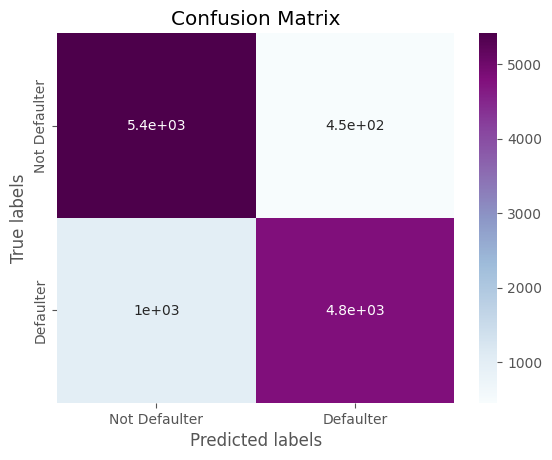

In [66]:
get_confusion_matrix(xgbc_pred)

#### We got the maximum accuracy and F1 score by training model on Random Forest Algorithm. Thus we choose this model for predicting default state of a borrower. Following graph shows relative feature importance in the model.

In [67]:
def get_feature_importance(clsf, ftrs):
    imp = clsf.feature_importances_.tolist()
    feat = ftrs
    result = pd.DataFrame({'feat':feat,'score':imp})
    result = result.sort_values(by=['score'],ascending=False)
    return result


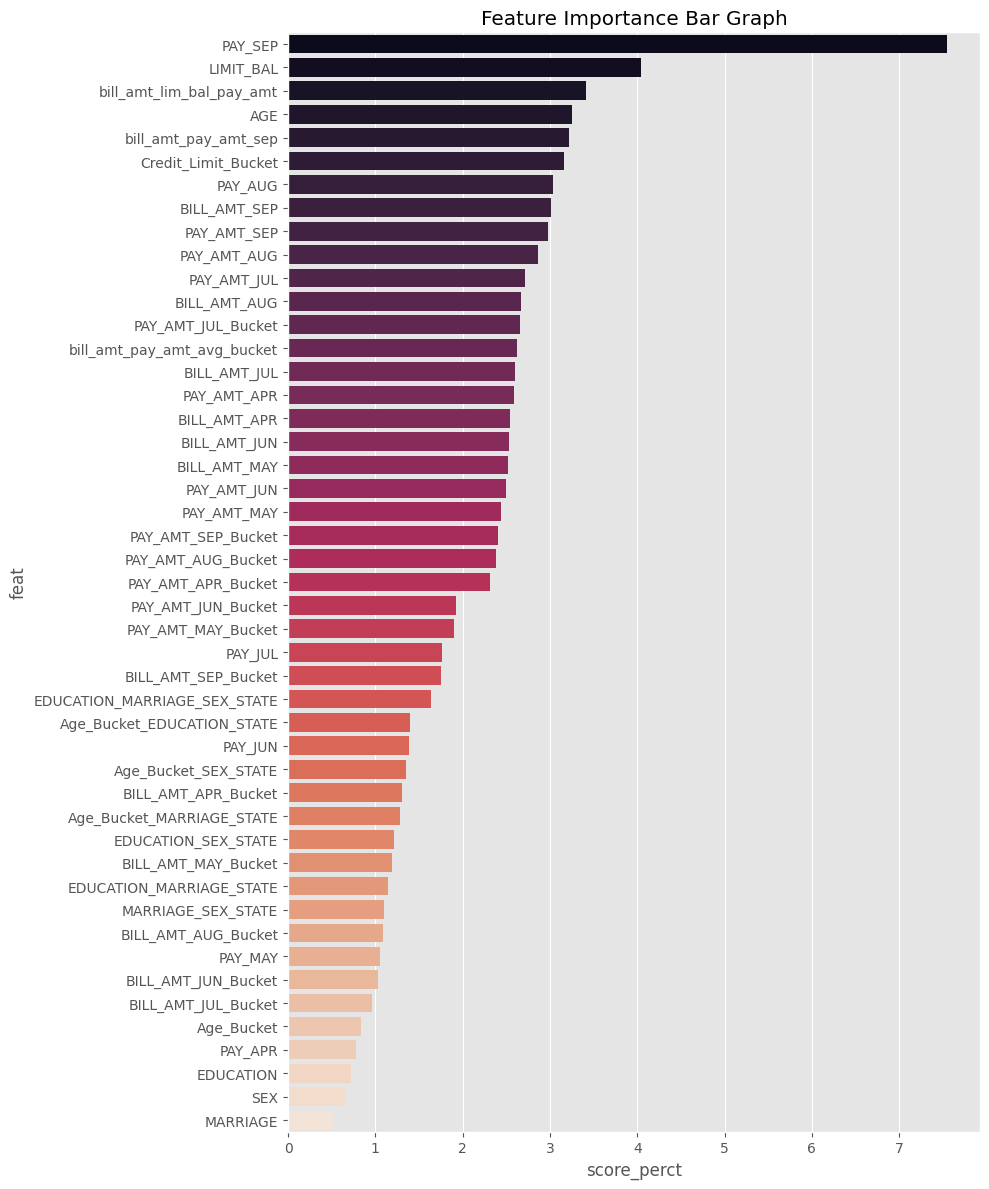

In [68]:
plt.figure(figsize=(10,12))
feat_imp = get_feature_importance(optimized_rf, X.columns)
feat_imp['score_perct'] = feat_imp['score'] * 100
sns.barplot(data = feat_imp,x='score_perct',y='feat',palette='rocket',orient = 'h')
plt.title('Feature Importance Bar Graph')
plt.tight_layout()